In [1]:
import pandas as pd
import sys
import os
from sentence_transformers import SentenceTransformer
import umap
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('~/Documents/papers/iass-mcc-twitter-colab/data/all_tweets.csv',lineterminator='\n')
df = df[~df.text.str.match('^RT @')]
print(df.shape)
df.head()

(2498212, 4)


,id,created_at,text,author_id
0,1408295995507568642,2021-06-25 05:28:24+00:00,"‘’Today, it’s residents of inner-city Sydney t...",267570919
1,1413014175731773440,2021-07-08 05:56:46+00:00,“ Johnson is fed up with the rules. Collective...,267570919
2,1414403414679703554,2021-07-12 01:57:07+00:00,“It took a while for Reaganism to arrive in Au...,267570919
3,1430320029644455941,2021-08-25 00:04:03+00:00,“The question is not whether Australians want ...,267570919
4,1411115958031187973,2021-07-03 00:13:56+00:00,References to Morrison’s so called plan as cha...,267570919


In [3]:
author_df = pd.read_csv('~/Documents/papers/iass-mcc-twitter-colab/data/all_parliamentarians.csv').rename(columns={"id":"author_id"})
print(author_df.shape)
author_df.head()

(2368, 13)


,Nachname,Vorname,Fraktion,Twitter-Name,region,"Name, Vorname",Vorname Nachname,handle,party,parltype,person__in_parlperiod,lcasehandle,author_id
0,Ahrens,Sandra,CDU,@sandraAhrens,Bremen,NaN,NaN,sandraAhrens,CDUCSU,Land,NaN,sandraahrens,2.565034e+08
1,Aulepp,Sascha Karolin,SPD,NaN,Bremen,NaN,NaN,NaN,SPD,Land,NaN,NaN,NaN
2,Averwerser,Yvonne,CDU,@Yaverwerser,Bremen,NaN,NaN,Yaverwerser,CDUCSU,Land,NaN,yaverwerser,1.135974e+18
3,Beck,Peter,Liberal-Konservative Reformer,NaN,Bremen,NaN,NaN,NaN,other,Land,NaN,NaN,NaN
4,Bensch,Rainer,CDU,@BenschRainer,Bremen,NaN,NaN,BenschRainer,CDUCSU,Land,NaN,benschrainer,8.905828e+17


In [4]:
df = df.merge(author_df[['author_id','region','party','parltype']],how="left")
print(df.shape)
df.head()

(2503162, 7)


,id,created_at,text,author_id,region,party,parltype
0,1408295995507568642,2021-06-25 05:28:24+00:00,"‘’Today, it’s residents of inner-city Sydney t...",267570919,NaN,NaN,NaN
1,1413014175731773440,2021-07-08 05:56:46+00:00,“ Johnson is fed up with the rules. Collective...,267570919,NaN,NaN,NaN
2,1414403414679703554,2021-07-12 01:57:07+00:00,“It took a while for Reaganism to arrive in Au...,267570919,NaN,NaN,NaN
3,1430320029644455941,2021-08-25 00:04:03+00:00,“The question is not whether Australians want ...,267570919,NaN,NaN,NaN
4,1411115958031187973,2021-07-03 00:13:56+00:00,References to Morrison’s so called plan as cha...,267570919,NaN,NaN,NaN


In [5]:
df = df[pd.notna(df['party'])]
df = df[df['region']=="Bund"]

import datetime
import pytz


df['party'] = df['party'].str.upper()

df.shape

(1137113, 7)

In [6]:
df.created_at = pd.to_datetime(df['created_at'])
cutoff = datetime.datetime(2021,1,1,tzinfo=pytz.UTC)

df = df[df['created_at']>cutoff]
df = df.set_index('created_at')
print(df.shape)
df.head()

(157261, 6)


,id,text,author_id,region,party,parltype
created_at,,,,,,
2021-08-24 09:11:23+00:00,1430095381593985024,"@rainerfaus @bertpsch Ja, im Freundes- und Bek...",52024480,Bund,GRUENE,Bund
2021-09-02 07:35:26+00:00,1433332723985391616,"""Wir müssen Raum schaffen"", sagt Janecek, Raum...",52024480,Bund,GRUENE,Bund
2021-08-09 22:16:01+00:00,1424857024454696968,„Baerbocks Rede dreht sich zunächst vor allem ...,52024480,Bund,GRUENE,Bund
2021-08-24 06:42:55+00:00,1430058016997617683,"Ich freue mich, kommenden Montag die Spitzenka...",52024480,Bund,GRUENE,Bund
2021-06-21 22:08:05+00:00,1407098021989470218,Wenn der Technologieturbo so gut funktioniert ...,52024480,Bund,GRUENE,Bund


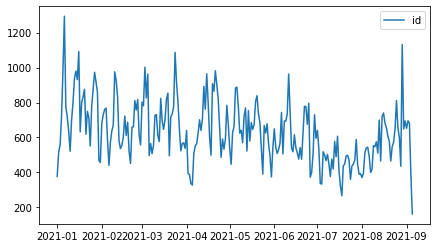

In [7]:
fig, ax = plt.subplots(figsize=(7,4))
counts = df.groupby(df.index.date)['id'].count().astype(int).to_frame()
counts.plot(ax=ax)

In [8]:
import datetime
import pytz
topics = [
    {"name":"Bildung","keywords":["bildung", "schul", "pisa-studie", "unterricht", "lehrer", "ausbildung"]},
    {"name":"Renten","keywords":["rente", "altersvorsorge", "altersarmut"]},
    {"name":"Ausländer & Geflüchtete","keywords":["ausländer", "geflüchtete","migration","migrant","zuwander","integration", "schleuser", "seenotrettung", "flüchtling", "asyl", "europäische außengrenze", "einwander"]},
    {"name":"Umwelt & Klima","keywords":["umwelt", "klima","ökolog", "energiewende", "artenvielfalt", "artensterben", "naturschutz", "globale erwärmung", "erderwärmung", "1,5-Grad-Ziel", "Pariser Abkommen", "Fridays for Future", "Treibhausgas", "fossiler Brennstoff", "fossile Brennstoffe", "CO2-Budget", "Ozonschicht", "Artensterben", "kohleausstieg", "IPCC"]},
    {"name":"Soziales Gefälle","keywords":["armut", "ungleichheit", "hartz"]},
    {"name":"Corona","keywords":["corona", "covid","impf", "schnelltest", "pcr", "lockdown", "kontaktbeschränkung"]},
    {"name":"Hochwasser & Katastrophenschutz","keywords":["hochwasser", "flut","katastrophe", "ahrtal"]},
    {"name":"Politikverdruss","keywords":["bananenrepublik", "politikverdross", "nichtwähler", "abgehängt"]},
    {"name":"Gesundheitswesen & Pflege","keywords":["krankenh[äa]us","pflege"]},
    {"name":"Arbeitslosigkeit","keywords":["arbeitslos", "hartz", "jobcenter", "sozialhilfe", "alg"]},
    {"name":"Wirtschaftslage","keywords":["wirtschaft", "konjunktur","ökonom"]},
    {"name":"Rechte & AfD","keywords":["rechtsextremismus", "neurechte", "neue rechte"]},
    {"name":"Mieten/Wohnungsmarkt","keywords":["miet", "wohnungsmarkt", "wohnraum", "deutsche wohnen", "akelius", "vonovia", "nachverdichtung", "enteignungen", "bauen bauen", "bauen, bauen"]},
    {"name":"gesellschaftlicher Zusammenhalt","keywords":["gesellschaftlicher zusammenhalt"]},
    {"name":"Bundestagswahl","keywords":["bundestagswahl", "btw21", "btw2021", "wahl 2021", "zwangsräum", "zwangsgeräum"]},
    {"name":"Infrastruktur/schnelles Internet","keywords":["infrastruktur", "breitband", "schnelle[sm] internet", "digitalisierung", "4G", "3G"]},
]
print(len(topics))
topic_names = []
redo = True
#df = df[df.index>datetime.datetime(2019,1,1,tzinfo=pytz.UTC)]
for t in topics:
    print(t)
    topic_names.append(t["name"])
    if t["name"] in df.columns:
        if not redo:
            continue
    df[t["name"]] = 0
    for term in t["keywords"]:
        df.loc[df['text'].str.lower().str.contains(term.lower()),t["name"]] = 1

df.head()

16
{'name': 'Bildung', 'keywords': ['bildung', 'schul', 'pisa-studie', 'unterricht', 'lehrer', 'ausbildung']}
{'name': 'Renten', 'keywords': ['rente', 'altersvorsorge', 'altersarmut']}
{'name': 'Ausländer & Geflüchtete', 'keywords': ['ausländer', 'geflüchtete', 'migration', 'migrant', 'zuwander', 'integration', 'schleuser', 'seenotrettung', 'flüchtling', 'asyl', 'europäische außengrenze', 'einwander']}
{'name': 'Umwelt & Klima', 'keywords': ['umwelt', 'klima', 'ökolog', 'energiewende', 'artenvielfalt', 'artensterben', 'naturschutz', 'globale erwärmung', 'erderwärmung', '1,5-Grad-Ziel', 'Pariser Abkommen', 'Fridays for Future', 'Treibhausgas', 'fossiler Brennstoff', 'fossile Brennstoffe', 'CO2-Budget', 'Ozonschicht', 'Artensterben', 'kohleausstieg', 'IPCC']}
{'name': 'Soziales Gefälle', 'keywords': ['armut', 'ungleichheit', 'hartz']}
{'name': 'Corona', 'keywords': ['corona', 'covid', 'impf', 'schnelltest', 'pcr', 'lockdown', 'kontaktbeschränkung']}
{'name': 'Hochwasser & Katastrophensch

,id,text,author_id,region,party,parltype,Bildung,Renten,Ausländer & Geflüchtete,Umwelt & Klima,...,Hochwasser & Katastrophenschutz,Politikverdruss,Gesundheitswesen & Pflege,Arbeitslosigkeit,Wirtschaftslage,Rechte & AfD,Mieten/Wohnungsmarkt,gesellschaftlicher Zusammenhalt,Bundestagswahl,Infrastruktur/schnelles Internet
created_at,,,,,,,,,,,,,,,,,,,,,
2021-08-24 09:11:23+00:00,1430095381593985024,"@rainerfaus @bertpsch Ja, im Freundes- und Bek...",52024480,Bund,GRUENE,Bund,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-09-02 07:35:26+00:00,1433332723985391616,"""Wir müssen Raum schaffen"", sagt Janecek, Raum...",52024480,Bund,GRUENE,Bund,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2021-08-09 22:16:01+00:00,1424857024454696968,„Baerbocks Rede dreht sich zunächst vor allem ...,52024480,Bund,GRUENE,Bund,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2021-08-24 06:42:55+00:00,1430058016997617683,"Ich freue mich, kommenden Montag die Spitzenka...",52024480,Bund,GRUENE,Bund,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2021-06-21 22:08:05+00:00,1407098021989470218,Wenn der Technologieturbo so gut funktioniert ...,52024480,Bund,GRUENE,Bund,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df_importance = pd.read_csv('data/BTW2021_probleme_forschungsgruppe.csv')
df_importance['Datum'] = pd.to_datetime(df_importance['Datum'],format="%d.%m.%y")
df_importance['last_date'] = df_importance['Datum'].shift(1)
df_importance = df_importance[df_importance['Datum']>cutoff.replace(tzinfo=None)]
df_importance.tail()

,Datum,A:Bildung,A:Renten,A:Ausländer & Geflüchtete,A:Umwelt & Klima,A:Soziales Gefälle,A:Corona,A:Hochwasser & Katastrophenschutz,A:Politikverdruss,A:Gesundheitswesen & Pflege,...,A:Mieten/Wohnungsmarkt,gesellschaftlicher Zusammenhalt,Bundestagswahl,Infrastruktur/schnelles Internet,Institut,Frage,Link,Erhebungszeitraum,Befragte,last_date
393,2021-06-25,8,7.0,10.0,34.0,9,45.0,NaN,7,3.0,...,2.0,NaN,NaN,NaN,Forschungsgruppe Wahlen: Politbarometer,Was ist Ihrer Meinung nach gegenwärtig das wic...,https://www.forschungsgruppe.de/Umfragen/Polit...,Dienstag bis Donnerstag vor Veröffentlichung a...,ca. 1250,2021-06-10
394,2021-07-16,6,6.0,11.0,34.0,10,50.0,NaN,5,3.0,...,2.0,NaN,NaN,NaN,Forschungsgruppe Wahlen: Politbarometer,Was ist Ihrer Meinung nach gegenwärtig das wic...,https://www.forschungsgruppe.de/Umfragen/Polit...,Dienstag bis Donnerstag vor Veröffentlichung a...,ca. 1250,2021-06-25
395,2021-07-30,4,5.0,11.0,44.0,7,45.0,12.0,6,3.0,...,2.0,4.0,NaN,NaN,Forschungsgruppe Wahlen: Politbarometer,Was ist Ihrer Meinung nach gegenwärtig das wic...,https://www.forschungsgruppe.de/Umfragen/Polit...,Dienstag bis Donnerstag vor Veröffentlichung a...,ca. 1250,2021-07-16
396,2021-08-13,4,NaN,10.0,44.0,8,50.0,9.0,7,NaN,...,NaN,NaN,4.0,NaN,Forschungsgruppe Wahlen: Politbarometer,Was ist Ihrer Meinung nach gegenwärtig das wic...,https://www.forschungsgruppe.de/Umfragen/Polit...,Dienstag bis Donnerstag vor Veröffentlichung a...,ca. 1250,2021-07-30
397,2021-09-03,6,10.0,13.0,38.0,11,35.0,NaN,7,4.0,...,4.0,NaN,NaN,4.0,Forschungsgruppe Wahlen: Politbarometer,Was ist Ihrer Meinung nach gegenwärtig das wic...,https://www.forschungsgruppe.de/Umfragen/Polit...,Dienstag bis Donnerstag vor Veröffentlichung a...,ca. 1250,2021-08-13


In [10]:
cdict = {'afd': '#009EE0',
 'bp': None,
 'cducsu': '#000000',
 'dp': None,
 'drp': None,
 'dzp': None,
 'fdp': '#FFED00',
 'fraktionslos': None,
 'gb/bhe': None,
 'gruene': '#64A12D',
 'kpd': None,
 'linke': '#8C3473',
 'other': None,
 'parteilos': None,
 'pds': None,
 'spd': '#EB001F',
 'wav': None}

In [11]:
non_thematic = df[df[topic_names].sum(axis=1)==0]
df = df[df[topic_names].sum(axis=1)>0]


In [12]:
non_thematic.head().text.values

array(['@rainerfaus @bertpsch Ja, im Freundes- und Bekanntenkreis. In sozialen Netzwerken. Gemeckert wird eher im inneren Kreis. „Draußen“ viel positive Resonanz. 😉',
       '@Reihner_pop @Labonitamascota @hmustr Sicherlich. Aber es wird auch in der Zukunft Autos geben, und dann lieber elektrisch/erneuerbar/leichter. Leben ja nicht alle Menschen in Städten. Städten und Ballungszentren sollten ihre Potentiale für autofreie Mobilität konsequent nutzen. Da geht noch ganz viel.',
       'Hatte ich schon erwähnt, dass gegen einen aufgeblähten Bundestag Grüne Direktmandate helfen? #CSUAbwählen https://t.co/oLNqVKs8Qq https://t.co/ADwqU0gk9B',
       'Ich habe großen Respekt vor der Initiative „Maria 2.0“, in der sich hunderte katholischer Frauen für mehr Toleranz in der Katholischen Kirche einsetzen. Aber auch Priester wie @WolfgangFRothe verdienen unsere volle Unterstützung. 🌈💚👍\n@gudruncita \nhttps://t.co/h23xdgtPxr',
       '@HuebnerJohannes @beerenstark @janoschdahmen Ich bin da wie imme

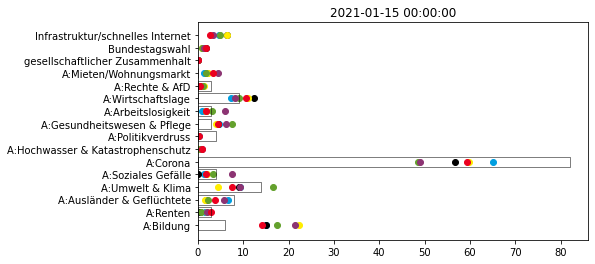

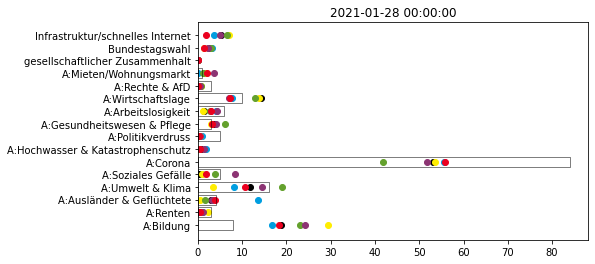

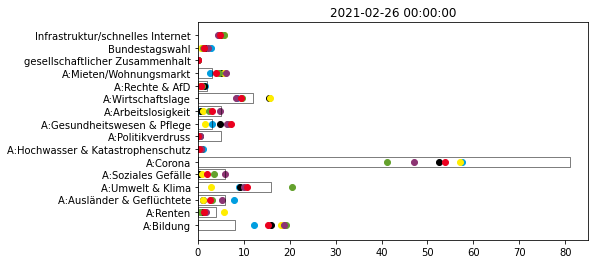

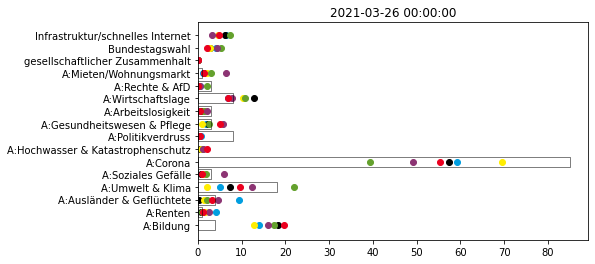

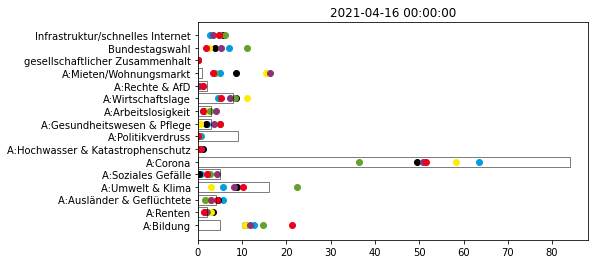

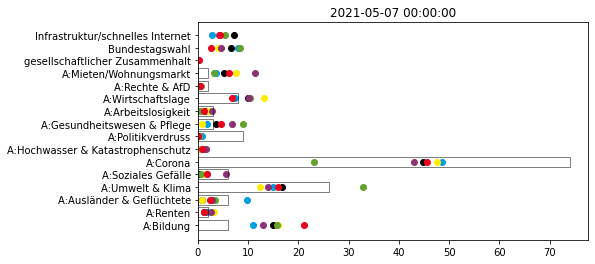

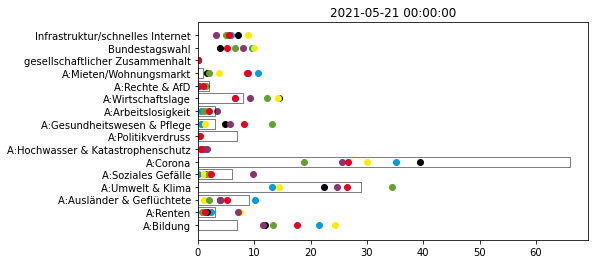

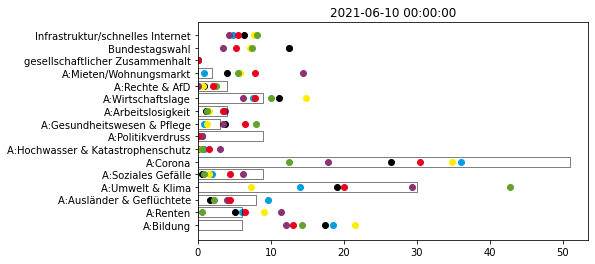

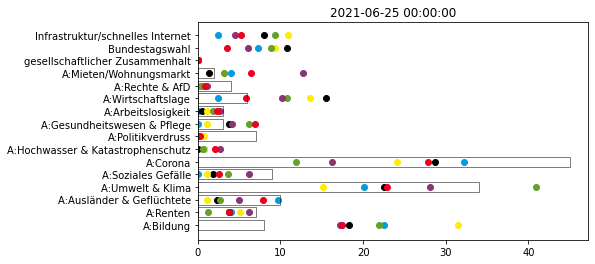

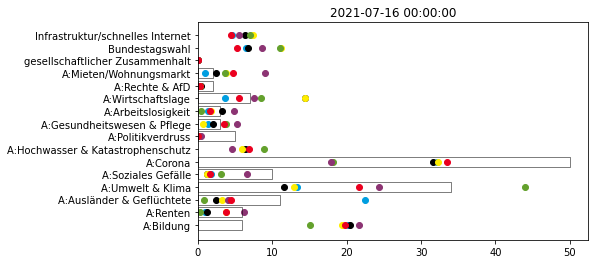

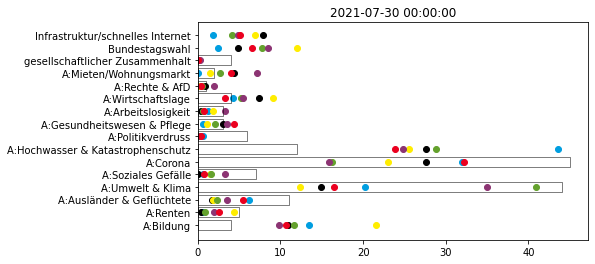

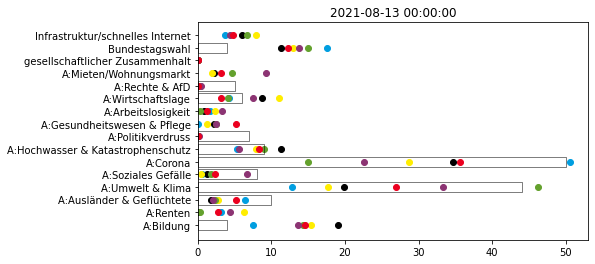

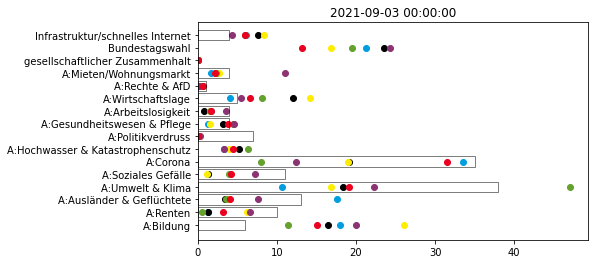

In [13]:
cols = df_importance.columns[1:-6]
for i, row in df_importance.iterrows():
    fig, ax = plt.subplots(figsize=(7,4))
    sub_df = df[
        (df.index>row['last_date'].replace(tzinfo=pytz.UTC)) & 
        (df.index<row['Datum'].replace(tzinfo=pytz.UTC))
    ]
    for j,c in enumerate(cols):
        ax.barh(j,row[c],color="None",ec="black",lw=0.5)
        for p, group in sub_df.groupby('party'):
            pg_col = [x for x in topic_names if x in c][0]
            prop = group[pg_col].sum()/group.shape[0]*100
            ax.scatter(prop,j, color=cdict[p.lower()])
        
    ax.set_yticks(range(len(cols)))
    ax.set_yticklabels(cols)
    
    ax.set_ylim(ymax=len(cols))
    
    ax.set_title(row['Datum'])
    
    plt.savefig(f"plots/date/topic_attention_{row['Datum']}.png",bbox_inches="tight")
    plt.savefig(f"plots/date/topic_attention_{row['Datum']}.pdf",bbox_inches="tight")

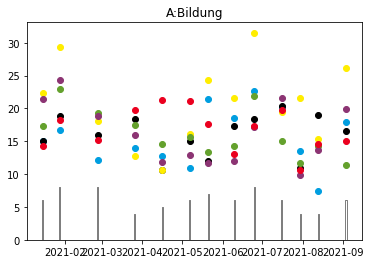

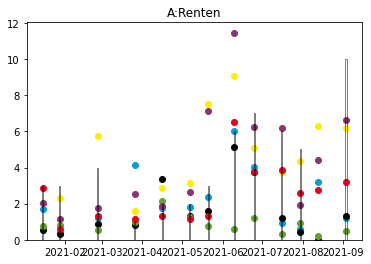

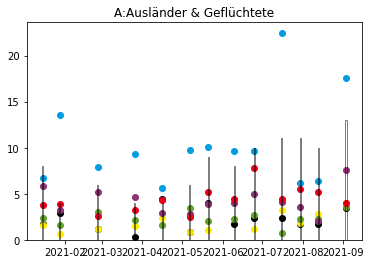

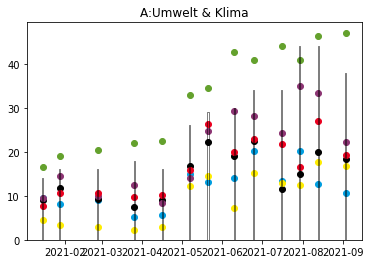

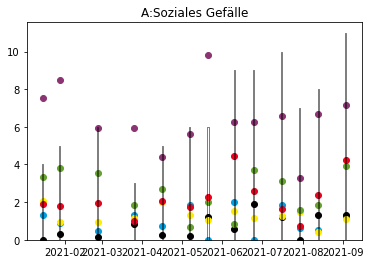

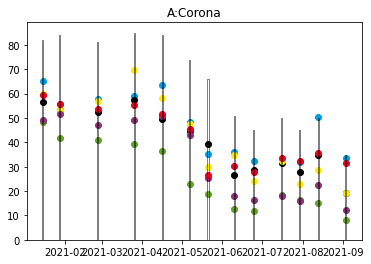

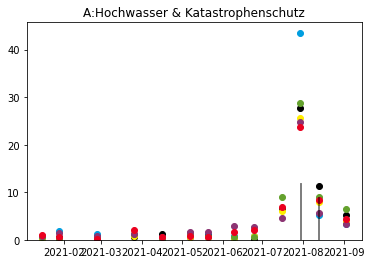

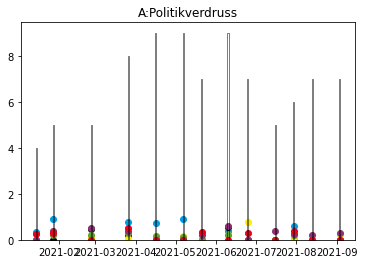

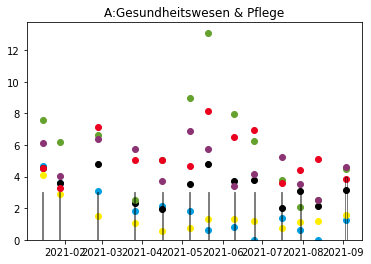

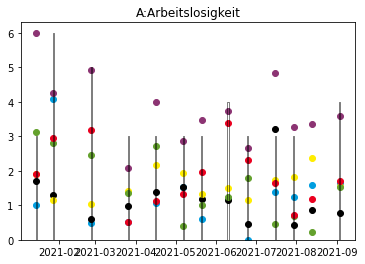

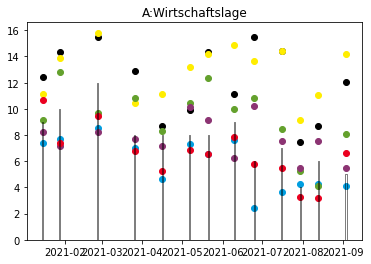

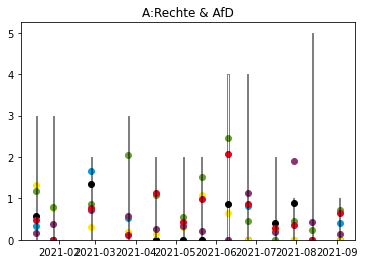

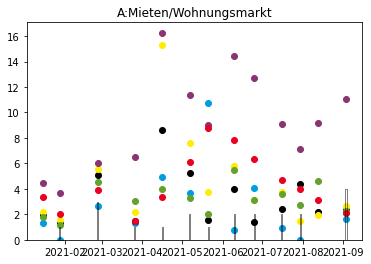

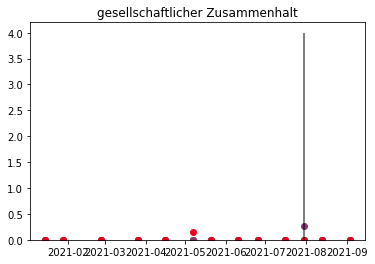

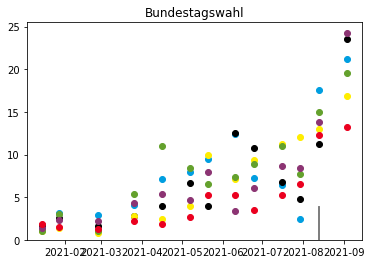

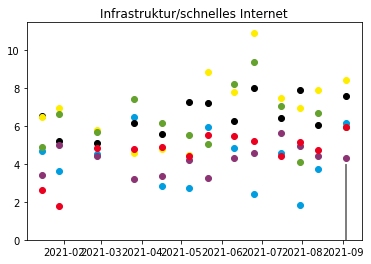

In [14]:
cols = df_importance.columns[1:-6]


for j,c in enumerate(cols):
    
    fig, ax = plt.subplots()

    for i, row in df_importance.iterrows():
        
        x = row['Datum']
        
        sub_df = df[
            (df.index>row['last_date'].replace(tzinfo=pytz.UTC)) & 
            (df.index<row['Datum'].replace(tzinfo=pytz.UTC))
        ]

        ax.bar(x,row[c],color="None",ec="black",lw=0.5)
        for p, group in sub_df.groupby('party'):
            pg_col = [x for x in topic_names if x in c][0]
            prop = group[pg_col].sum()/group.shape[0]*100
            ax.scatter(x, prop, color=cdict[p.lower()])
    
    ax.set_title(c)
    
    plt.savefig(f"plots/topic/topic_attention_{c.replace('/','_')}.png",bbox_inches="tight")
    plt.savefig(f"plots/topic/topic_attention_{c.replace('/','_')}.pdf",bbox_inches="tight")

In [15]:
df['id'] = df['id'].astype(int)
df['text'] = df['text'].str.replace('\r','')
df.reset_index().to_csv('source_data/annotated_tweets.csv',index=False)